In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Markdown
from IPython.display import display

import glob
import json
import warnings
import networkx as nx
import collections

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

In [2]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [3]:
graph = nx.read_gpickle("./fakes_tweets/small_graph.pkl")

print(graph)

DiGraph with 77118 nodes and 6673 edges


In [4]:
nodes = nx.get_node_attributes(graph, "author_id")
len(nodes)

77118

In [5]:
graph = graph.subgraph(list(nodes.keys()))
print(graph)

DiGraph with 77118 nodes and 6673 edges


## Build dataset

In [6]:
def construct_ds(graph: nx.DiGraph):
    user_replies = []
    user_ids = []
    for n_id, data in graph.nodes(data=True):
        if "text" in data:
            """user_replies.append({
                "user_ids": str(data["author_id"]),
                "text": str(data["text"]),
                "tweet_id": str(n_id)
            })"""
            for e_id in graph.successors(n_id):
                u_id = graph.nodes[e_id].get("author_id", None)
                if not (u_id is None):
                    user_replies.append({
                        "user_ids": u_id,
                        "text": data["text"],
                        "tweet_id": n_id
                    })
                    user_ids.append([n_id, u_id])
                else:
                    print(u_id)
    return user_replies, user_ids

In [7]:
user_replies, user_ids = construct_ds(graph)

# print(user_ids[0])
print(len(user_ids), len(user_replies))

6673 6673


In [8]:
user_replies[0].keys()

dict_keys(['user_ids', 'text', 'tweet_id'])

In [9]:
df = pd.DataFrame(user_replies)
df.sample(10)

,user_ids,text,tweet_id
6659,199585426,"A Discussion about Fraud and ""Vaccines"" and th...",1505526927259484163
1352,454007741,Doug Ford won't allow masks to be mandated in ...,1505523012610707456
5174,850710096032092160,I was thinking how good it would be if all of ...,1505398251658219522
5940,136591386,Sleazy is raking in £7MILLION A DAY in VAT on ...,1505692221844209665
330,28375334,"How could a box ""KC Novel Coronavirus Vaccine""...",1505376114256003075
5136,1491776087684104193,#stayhome #onlinejobs Accounts Payable Clerk -...,1505033052904468487
5848,1485439106578456577,REAL PEOPLE ARE REALLY DYING FROM #COVID BECAU...,1505625081053171712
3553,120603927,And it’s because of people like you that no on...,1505581030916431883
3570,1160964450,And it’s because of people like you that no on...,1505581030916431883
2626,964336968812253184,Blessings \n🙏 \n. https://t.co/c2t3pX1RH9,1505401161314373632


In [10]:
user_count = df.user_ids.value_counts().sort_values()
user_count.describe()

count    2318.000000
mean        2.878775
std         4.507555
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        77.000000
Name: user_ids, dtype: float64

In [11]:
user_count = user_count[user_count>4]
user_count.shape

(297,)

In [12]:
df = df[df.user_ids.isin(user_count.index)]
df.shape

(3114, 3)

In [13]:
df["text"] = df.text.apply(lambda x: " ".join(tf.keras.preprocessing.text.text_to_word_sequence(x)))

In [14]:
np.random.seed(1000)

In [15]:
train = df.groupby("user_ids").sample(frac=0.8)
test = df.drop(index=train.index)

In [16]:
df.shape, train.shape, test.shape

((3114, 3), (2504, 3), (610, 3))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 6670
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_ids  3114 non-null   object
 1   text      3114 non-null   object
 2   tweet_id  3114 non-null   object
dtypes: object(3)
memory usage: 161.9+ KB


In [18]:
def apply_embedding(x):
    return list(x)[0]

In [19]:
tweet_repr = df.groupby("tweet_id").agg({"text": apply_embedding})
tweet_repr.head()

,text
tweet_id,
1504992458111086592,safeschoolsny tedhminhi drleanawen wolfblitzer...
1504992768506368001,graham moloney2 in au watch video premier of n...
1504992890740686850,integrity is a good look ocdsb should take not...
1504993470888488971,pfizermule my goodness contrarian non experts ...
1504994082732797953,9 in 10 covid deaths are in vaccinated people ...


In [20]:
tweet_repr.shape

(1210, 1)

In [21]:
tweet_replies = tf.data.Dataset.from_tensor_slices(
    {
        "text": train.text.values,
        "user_id": train.user_ids.values
    }
)

test_replies = tf.data.Dataset.from_tensor_slices(
    {
        "text": test.text.values,
        "user_id": test.user_ids.values
    }
)

tweets = tf.data.Dataset.from_generator(
    lambda: train.text.unique(),
    tf.string, output_shapes= ()
)

In [22]:
tweet_replies

<TensorSliceDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [23]:
tweets

<FlatMapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [24]:
users = set(df.user_ids)
print(len(users))

297


In [25]:
class UserModel(tf.keras.Model):
    def __init__(self, users_id, embedding_size=64):
        super().__init__()
        
        users_id = list(set(users_id))

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=users_id, mask_token=None),
            tf.keras.layers.Embedding(len(users_id) + 1, embedding_size),
        ])

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return self.user_embedding(inputs["user_id"])

In [26]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, users_id, layer_sizes, embedding_size=64):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel(users_id, embedding_size)

        # Then construct the layers.
        self.dense_layers = tfrs.layers.blocks.MLP(
            units = layer_sizes,
            use_bias = True,
            activation = 'relu',
            final_activation = None
        )

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [27]:
class TweetModel(tf.keras.Model):
    def __init__(self, tweets, embedding_dim = 100, max_tokens = 10000):
        super().__init__()
        
        self.tweet_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens,)
        self.tweet_vectorizer.adapt(tweets)
            
        self.tweet_text_embedding = tf.keras.Sequential([
            self.tweet_vectorizer,
            tf.keras.layers.Embedding(
                max_tokens, 
                embedding_dim,
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

    def call(self, tweets):
        return self.tweet_text_embedding(tweets)

In [28]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, tweets, layer_sizes, embedding_dim = 100,  max_tokens = 10000):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = TweetModel(tweets, embedding_dim, max_tokens)

        # Then construct the layers.
        self.dense_layers = tfrs.layers.blocks.MLP(
            units = layer_sizes,
            use_bias = True,
            activation = 'relu',
            final_activation = None
        )

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [29]:
class TweetRecModel(tfrs.models.Model):

    def __init__(self, tweets, layer_sizes, users_id, user_embedding_dim = 100, tweet_embedding_size=64, max_tokens = 10000):
        super().__init__()
        self.query_model = QueryModel(users_id, layer_sizes, user_embedding_dim)
        self.candidate_model = CandidateModel(tweets, layer_sizes, tweet_embedding_size,  max_tokens)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tweets.batch(1024).map(self.candidate_model),
                # k=4
            ),
        )

    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
        })
        movie_embeddings = self.candidate_model(features["text"])
        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training) # 

In [30]:
tf.random.set_seed(42)
shuffled = tweet_replies.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

In [31]:
cached_train = shuffled.batch(64)
cached_test = test_replies.batch(1024).cache()

In [32]:
cached_test

<CacheDataset element_spec={'text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>

In [33]:
num_epochs = 100

model = TweetRecModel(
    tweets=tweets, 
    layer_sizes=[500, 250, 64], # 500, 250,
    users_id=list(users), 
    user_embedding_dim = 100, 
    tweet_embedding_size=100, 
    max_tokens = 10000
)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=15,
    decay_rate=0.98,
    staircase=True)
))

In [34]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [35]:
one_layer_history = model.fit(
    cached_train,
    epochs=num_epochs,
    validation_freq=5,
    validation_data=cached_test,
    callbacks=my_callbacks
    # verbose=1,
)

Epoch 1/100
40/40 [==============================] - 1s 10ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 237.5231 - regularization_loss: 0.0000e+00 - total_loss: 237.5231
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 206.9880 - regularization_loss: 0.0000e+00 - total_loss: 206.9880
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factor

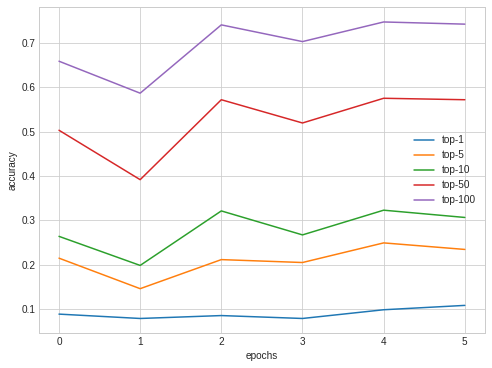

In [36]:
plt.plot(one_layer_history.history["val_factorized_top_k/top_1_categorical_accuracy"])
plt.plot(one_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"])
plt.plot(one_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"])
plt.plot(one_layer_history.history["val_factorized_top_k/top_50_categorical_accuracy"])
plt.plot(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.legend(["top-1", "top-5", "top-10", "top-50", "top-100"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

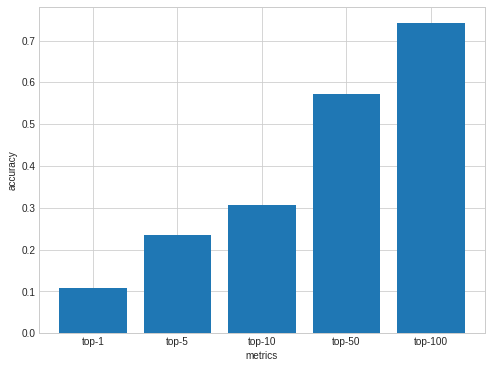

In [37]:
plt.bar(
    ["top-1", "top-5", "top-10", "top-50", "top-100"], 
    [
        one_layer_history.history["val_factorized_top_k/top_1_categorical_accuracy"][-1],
        one_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"][-1],
        one_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"][-1],
        one_layer_history.history["val_factorized_top_k/top_50_categorical_accuracy"][-1],
        one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1],
    ])

plt.xlabel("metrics")
plt.ylabel("accuracy")
plt.show()

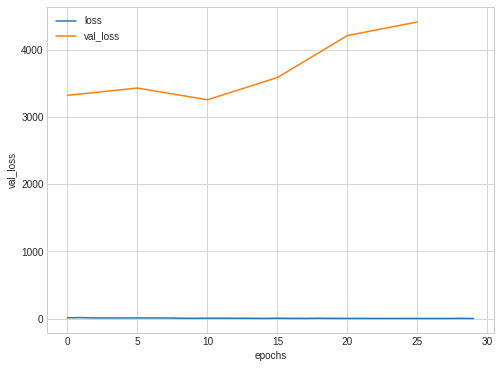

In [38]:
plt.plot(one_layer_history.history["loss"])
plt.plot([i*5 for i in range(len(one_layer_history.history["val_loss"]))], one_layer_history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel("epochs")
plt.ylabel("val_loss")
plt.show()

In [39]:
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 147ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1082 - factorized_top_k/top_5_categorical_accuracy: 0.2344 - factorized_top_k/top_10_categorical_accuracy: 0.3066 - factorized_top_k/top_50_categorical_accuracy: 0.5721 - factorized_top_k/top_100_categorical_accuracy: 0.7426 - loss: 4414.9897 - regularization_loss: 0.0000e+00 - total_loss: 4414.9897


{'factorized_top_k/top_1_categorical_accuracy': 0.10819672048091888,
 'factorized_top_k/top_5_categorical_accuracy': 0.23442623019218445,
 'factorized_top_k/top_10_categorical_accuracy': 0.30655738711357117,
 'factorized_top_k/top_50_categorical_accuracy': 0.5721311569213867,
 'factorized_top_k/top_100_categorical_accuracy': 0.742622971534729,
 'loss': 4414.98974609375,
 'regularization_loss': 0,
 'total_loss': 4414.98974609375}

In [40]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((tweets.batch(512), tweets.batch(512).map(model.candidate_model)))
)

In [41]:
# Get recommendations.
_, titles = index({"user_id": np.array(["2491664966"])})
print("Recommendations for user 2491664966:\n")
for tweet in titles[0, :5]:
    print(tweet)

Recommendations for user 2491664966:

tf.Tensor(b'anyone that follows me knows i actually advocate for vaccination ryan\xe2\x80\x99s behavior and the silence in response is why people are vaccine hesitant this behavior from a physician helps no one character counts', shape=(), dtype=string)
tf.Tensor(b"apollo walked into the clinic w out a mask workers asked him to put a mask on \xe2\x80\x9che said \xe2\x80\x98i don\xe2\x80\x99t need a mask i don\xe2\x80\x99t have the virus amp you are the ones making people sick \xe2\x80\x99 apollo clenched his fists as he denounced workers as 'murderers' amp lunged\xe2\x80\x9d https t co nfoyfsrjcv 03", shape=(), dtype=string)
tf.Tensor(b'cryptocurrencytrading do you believe the world will get back to normal finance wise after the pandemic craze is over i know there are many people out there will try to the night the pandemic or about will say the pandemic is over but we all know\xe2\x80\xa6 https t co vi8i48agzd', shape=(), dtype=string)
tf.Tensor(b

In [42]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((tweets.batch(512), tweets.batch(512).map(model.candidate_model)))
)

In [43]:
# Get recommendations.
_, titles = scann_index({"user_id": tf.constant(["2491664966"])})
print("Recommendations for user 2491664966: \n")
for tweet in titles[0, :5]:
    print(tweet)

Recommendations for user 2491664966: 

tf.Tensor(b"apollo walked into the clinic w out a mask workers asked him to put a mask on \xe2\x80\x9che said \xe2\x80\x98i don\xe2\x80\x99t need a mask i don\xe2\x80\x99t have the virus amp you are the ones making people sick \xe2\x80\x99 apollo clenched his fists as he denounced workers as 'murderers' amp lunged\xe2\x80\x9d https t co nfoyfsrjcv 03", shape=(), dtype=string)
tf.Tensor(b'anyone that follows me knows i actually advocate for vaccination ryan\xe2\x80\x99s behavior and the silence in response is why people are vaccine hesitant this behavior from a physician helps no one character counts', shape=(), dtype=string)
tf.Tensor(b'cryptocurrencytrading do you believe the world will get back to normal finance wise after the pandemic craze is over i know there are many people out there will try to the night the pandemic or about will say the pandemic is over but we all know\xe2\x80\xa6 https t co vi8i48agzd', shape=(), dtype=string)
tf.Tensor(

In [44]:
test[test.user_ids=="2491664966"]

,user_ids,text,tweet_id
